## Question 1 :



In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

#Importing Dependent Libraries
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import os

Mounted at /content/drive/


In [ ]:
#Reading the images
directory = '/content/drive/MyDrive/ENPM673/Project3/Part1/Frames/'
file_list = os.listdir(directory)
def extract_frame_number(filename):
    return int(filename.split('_')[1].split('.')[0])

# List all image files and sort them based on frame number
image_files = sorted([f for f in os.listdir(directory) if f.startswith('frame_') and f.endswith('.jpg')], key=extract_frame_number)

Link to the images taken : https://drive.google.com/drive/folders/1clQ69SnQ10ILduh4OimDk0foL_KpBgTj?usp=sharing

In [ ]:
i = 0
# Termination criteria :
#30 is the maximum number of iterations allowed and 0.001 is the desired accuracy/ epsilon
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points for a 7x9 board with 20mmx20mm squares
objp = np.zeros((7*9, 3), np.float32)
#To generate a set of 3D coordinates for the corners of a chessboard pattern in the real world, where each point is scaled by 20 units
objp[:, :2] = np.mgrid[0:7, 0:9].T.reshape(-1, 2) * 20
objpoints = []
imgpoints1 = []
imgpoints2=[]
corners_list_img1=[]
corners_list_img2=[]
# Load the images one by one
for image_file in image_files:
    image_path = os.path.join(directory, image_file)
    img = cv.imread(image_path)

    #Convert the image to gray
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    #Find the corners of the Chessboard pattern, the cv2 function
    ret, corners = cv.findChessboardCorners(gray, (7, 9), None)
    if ret:
        objpoints.append(objp)
        #Corner Refinement, 11,11 specifies the window size. Used to improve the accuracy of corner detection
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        #Append the obtained corners for the image to imgpoints1
        imgpoints1.append(corners2)
        #Drawing the chessboard pattern on the image
        # cv.drawChessboardCorners(img, (7,9), corners2, ret)
        # Append detected corners to the list
        corners_list_img1.append(corners2)
        # cv2_imshow(img)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break


#Obtaining the Camera's Intrinsic and Extrinsic Parameters
ret, cammtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints1, gray.shape[::-1], None, None)
print("The Corresponding Camera Matrix obtained is : \n ", cammtx)

#Undistorting the images using the camera matrix
j=1
# Load the images one by one
for image_file in image_files:
  image_path = os.path.join(directory, image_file)
  image = cv.imread(image_path)
  h, w = image.shape[:2]
  #Optimising the camera matrix
  newcameramtx, roi = cv.getOptimalNewCameraMatrix(cammtx, dist, (w, h), 1, (w, h))
  #undistorts an image using the camera matrix and distortion coefficients obtained from camera calibration, along with the optimal new camera matrix computed for undistortion.
  # dst = cv.undistort(image, cammtx, dist, None, newcameramtx)
  mapx,mapy = cv.initUndistortRectifyMap(cammtx,dist,None,newcameramtx,(w,h),5)
  dst = cv.remap(image,mapx,mapy,cv.INTER_LINEAR)
  #Converting to grayscale for chessboard corner detection
  dst1=cv.cvtColor(dst, cv.COLOR_BGR2GRAY)
  #Obtaining the chessboard corners for undistored images
  ret3,corners3= cv.findChessboardCorners(dst1, (7, 9), None)
  if ret3:
    #Corner Refinement, here 11,11 represents the window size used for refinement
    corners4 = cv.cornerSubPix(dst1, corners3, (11, 11), (-1, -1), criteria)
    #Store the obtained corners for undistorted image
    imgpoints2.append(corners4)
    #Drawing the chessboard pattern on the image
    corners_list_img2.append(corners4)  # Append detected corners to the list

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
  ax1.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
  ax1.set_title('Original Image_%d'%j)
  ax1.axis('off')
  ax2.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
  ax2.set_title('Undistorted Image_%d'%j)
  ax2.axis('off')
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/ENPM673/Project3/Outputs/Question1/undistorted_%d.jpg' % j)
  plt.show()
  j+=1

As the 50 images generated cannot be printed, I have added it to Drive File : https://drive.google.com/drive/folders/1jdW2v9bWtFoabU9YaLbg5UNggamV9-TW?usp=sharing

An example output from the drive is as follows

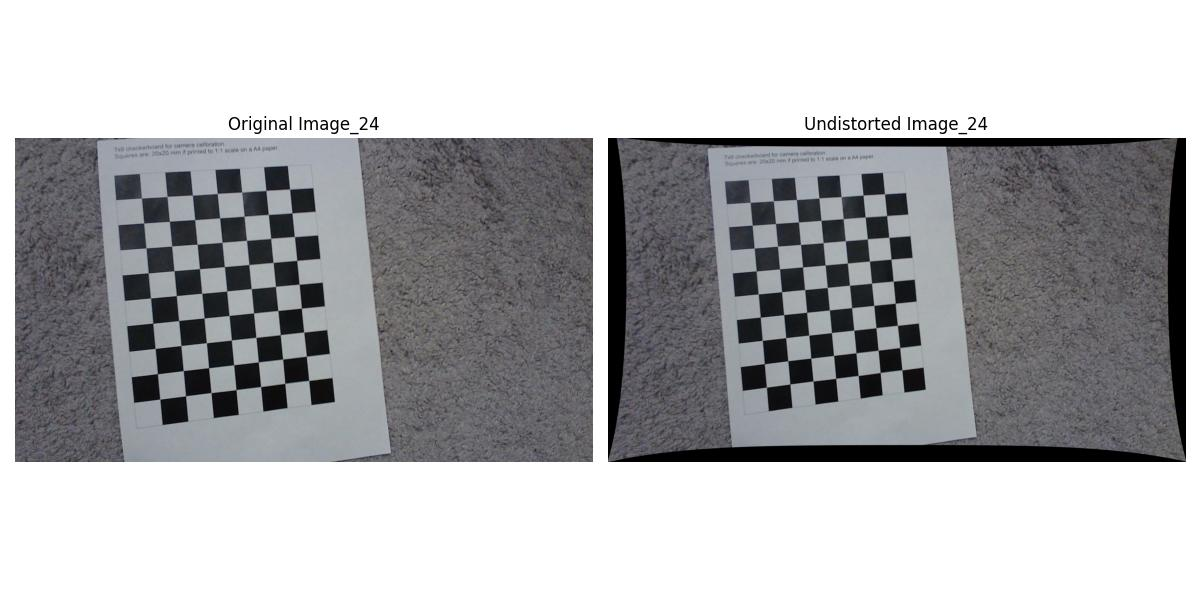

In [ ]:
undistortedimagecomparison= cv.imread('/content/drive/MyDrive/ENPM673/Project3/Outputs/Question1/undistorted_24.jpg')
cv2_imshow(undistortedimagecomparison)

Reprojection Error

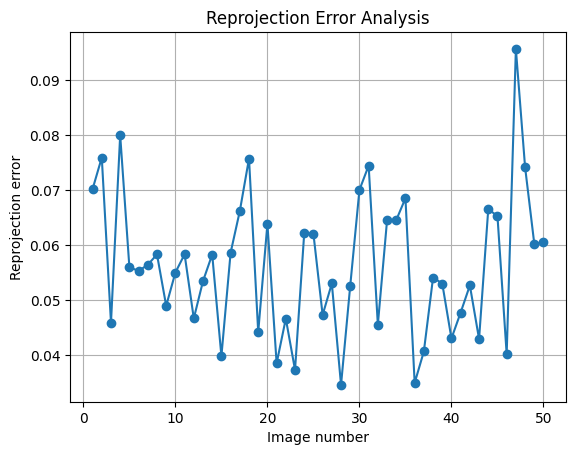

In [ ]:
#Store the projected image points for each image
corners_list2=[]
#Store the reprojection errors for each image
reprojection_errors=[]
for i in range (len(rvecs)):
  #Project 3D object points onto the image plane using the current rotation and translation vectors
  imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], cammtx, dist)
  #Calculate reprojection error by comparing the projected image points (imgpoints2) with the original image points (imgpoints1)
  error = cv.norm(imgpoints1[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
  #Store the reprojection error for this image
  reprojection_errors.append(error)
  #Store the projected image points for this image
  corners_list2.append(imgpoints2)

# Plotting the reprojection errors for each image
plt.plot(range(1, len(reprojection_errors) + 1), reprojection_errors, marker='o')
plt.xlabel('Image number')
plt.ylabel('Reprojection error')
plt.title('Reprojection Error Analysis')
plt.grid(True)
plt.show()


The Output of the below cell is in this folder, please use this link to access and visualise it : https://drive.google.com/drive/folders/1DBmGggZKlIFI4RemHkobeUI-dmRTc1rb?usp=sharing

In [ ]:
# Load the images one by one
count=0
for image_file in image_files:
  count+=1
  image_path = os.path.join(directory, image_file)
  print(image_path)
  image = cv.imread(image_path)

  idx = int(image_file.split('_')[-1].split('.')[0]) - 1
  corners_array = np.array(corners_list_img1[idx]).reshape(-1, 1, 2)
  undistorted_corners = cv.undistortPoints(np.array(corners_array), cammtx, dist, None, newcameramtx)

  # Draw detected corners on the image
  for corner in corners_list_img1[idx]:
      cv.circle(image, (int(corner[0][0]), int(corner[0][1])), 5, (0, 255, 0), -1)  # Green circles for original corners

  for corner in corners_list2[idx]:
      cv.circle(image, (int(corner[0][0]), int(corner[0][1])), 5, (0, 0, 255), -1)  # Red circles for image corners using project points

  # Map undistorted corners back to original image
  undistorted_corners = cv.undistortPoints(np.array(corners_list_img2[idx]), cammtx, dist, None, cammtx)

  for corner in undistorted_corners:
      cv.circle(image, (int(corner[0][0]), int(corner[0][1])), 5, (255, 255, 0), -1)  # Blue circles for undistorted image corners obtained using cv.undistortPoints

  # Display the image
  cv2_imshow(image)
  cv.imwrite('/content/drive/MyDrive/ENPM673/Project3/Outputs/Question1/calibrationresults/calibResults_%d.jpg' % count, image)
  cv.waitKey(0)

cv.destroyAllWindows()


Example output as the file was not printing, the images can be found in this folder : https://drive.google.com/drive/folders/1DBmGggZKlIFI4RemHkobeUI-dmRTc1rb?usp=sharing

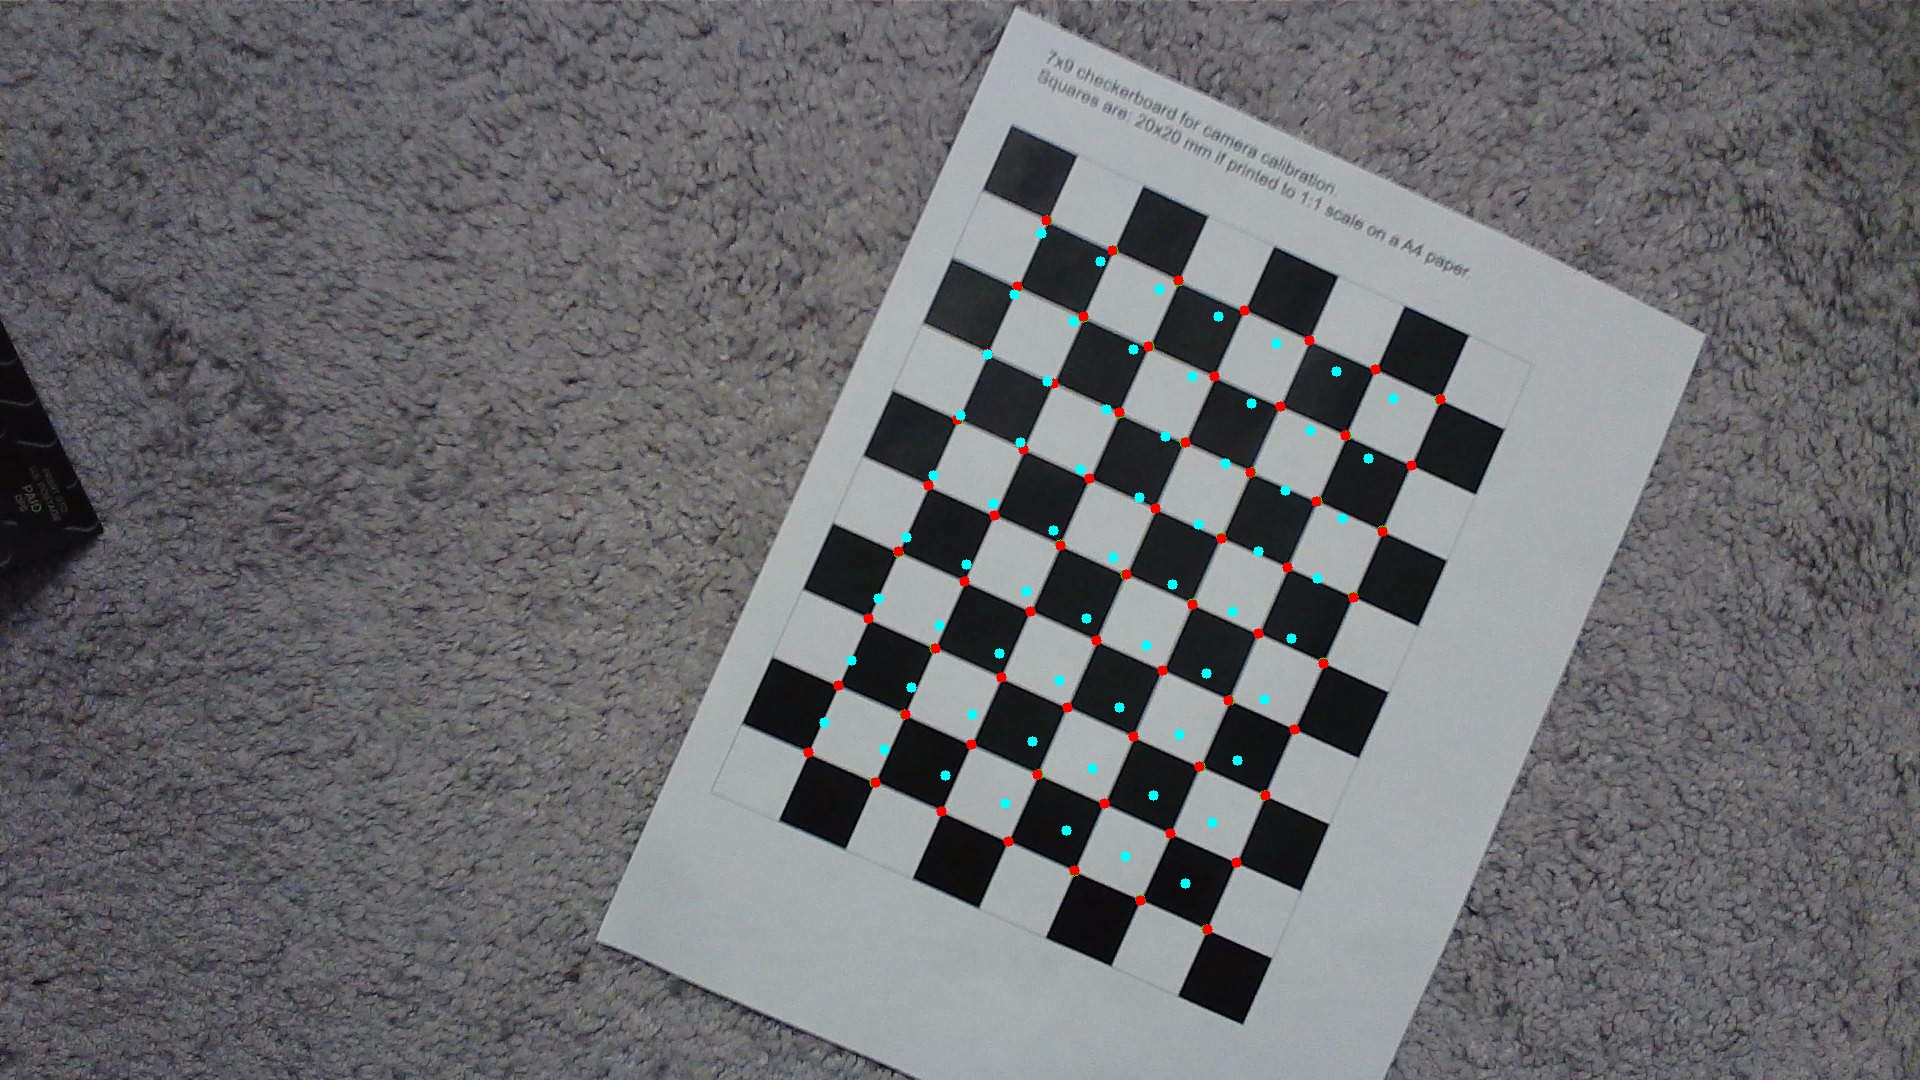

In [ ]:

cornerpointsaftercalibration= cv.imread('/content/drive/MyDrive/ENPM673/Project3/Outputs/Question1/calibrationresults/calibResults_13.jpg')
cv2_imshow(cornerpointsaftercalibration)